In [1]:
import random
import os

random.seed(42)

splits_folder = "splits"
adjudicated_data_file = "adjudicated-1.txt"

# Create the splits folder
if not os.path.exists(splits_folder):
    os.makedirs(splits_folder)

# Read the adjudicated.txt file
with open(adjudicated_data_file, "r") as f:
    adjudicated_data = [line.strip() for line in f.readlines()]

# Random shuffle the data
random.shuffle(adjudicated_data)

# Path to the shuffled file
shuffled_path = os.path.join(splits_folder, "adjudicated_data.txt")

# Write the shuffled data
with open(shuffled_path, "w") as f:
    f.write("\n".join(adjudicated_data) + "\n")

# Read the shuffled file to get its length
with open(shuffled_path, "r") as f:
    shuffled_length = sum(1 for line in f)

print("Length of adjudicated_data.txt:", shuffled_length, len(adjudicated_data))



# Calculate the sizes
total_data_points = len(adjudicated_data)
print("total_data_points:", total_data_points)

train_size = int(total_data_points * 0.6)
print("train_size:", train_size)

dev_size = int(total_data_points * 0.2)
print("dev_size:", dev_size)

test_size = int(total_data_points * 0.2)
print("test_size:", test_size)

# Split the data
train_data = adjudicated_data[ : train_size]
dev_data = adjudicated_data[train_size : train_size + dev_size]
test_data = adjudicated_data[train_size + dev_size : ]

# Path each of files
train_path = os.path.join("splits", "train.txt")
dev_path = os.path.join("splits", "dev.txt")
test_path = os.path.join("splits", "test.txt")

# Write the splits to separate files
with open(train_path, "w") as f:
    f.write("\n".join(train_data) + "\n")

with open(dev_path, "w") as f:
    f.write("\n".join(dev_data) + "\n")

with open(test_path, "w") as f:
    f.write("\n".join(test_data) + "\n")

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 5573: character maps to <undefined>

In [ ]:
# Check the length of train file
print("Length of adjudicated-1.txt:", total_data_points)

with open(train_path, "r") as f:
  train_length = sum(1 for line in f)
print("Length of train.txt: ", train_length, len(train_data))


with open(dev_path, "r") as f:
  dev_length = sum(1 for line in f)
print("Length of dev.txt: ", dev_length, len(dev_data))


with open(test_path, "r") as f:
  test_length = sum(1 for line in f)
print("Length of test.txt: ", test_length, len(test_data))

Length of adjudicated-1.txt: 500
Length of train.txt:  300 300
Length of dev.txt:  100 100
Length of test.txt:  100 100


# Logistic Regression with TF-IDF

In [ ]:
import numpy as np
import math
from collections import Counter
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from scipy.stats import norm
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

nltk.download('punkt')

def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.strip().split("\t")
            label = cols[2]
            text = cols[3]
            X.append(text)
            Y.append(label)
    return X, Y

class Classifier:
    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), use_idf=True)
        self.log_reg = None

        self.trainX = self.vectorizer.fit_transform(trainX)
        self.trainY = trainY
        self.devX = self.vectorizer.transform(devX)
        self.devY = devY
        self.testX = self.vectorizer.transform(testX)
        self.testY = testY

    def train(self):
        best_dev_accuracy = 0
        best_model = None
        for C in [0.1, 1, 10, 100]:
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(self.trainX, self.trainY)
            training_accuracy = model.score(self.trainX, self.trainY)
            development_accuracy = model.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy = development_accuracy
                best_model = model
            print(f"C: {C}, Train accuracy: {training_accuracy:.3f}, Dev accuracy: {development_accuracy:.3f}")

        self.log_reg = best_model

    def test(self):
        test_accuracy = self.log_reg.score(self.testX, self.testY)
        return test_accuracy

    def print_weights(self, n=10):
        feature_names = self.vectorizer.get_feature_names_out()
        for i, class_label in enumerate(self.log_reg.classes_):
            topn = np.argsort(self.log_reg.coef_[i])[-n:]
            print(f"Top features for class {class_label}:")
            for j in topn:
                print(f"{feature_names[j]}: {self.log_reg.coef_[i][j]:.3f}")
            print()

def confidence_intervals(accuracy, n, significance_level=0.05):
    critical_value = (1 - significance_level) / 2
    z_alpha = -1 * norm.ppf(critical_value)
    se = math.sqrt((accuracy * (1 - accuracy)) / n)
    return accuracy - (se * z_alpha), accuracy + (se * z_alpha)

def run(training_file, dev_file, test_file):
    trainX, trainY = load_data(training_file)
    devX, devY = load_data(dev_file)
    testX, testY = load_data(test_file)

    classifier = Classifier(trainX, trainY, devX, devY, testX, testY)
    classifier.train()
    test_accuracy = classifier.test()
    lower, upper = confidence_intervals(test_accuracy, len(testY))
    print(f"Test accuracy for best dev model: {test_accuracy:.3f}, 95% CIs: [{lower:.3f} {upper:.3f}]")

    classifier.print_weights()

    return classifier




training_file = "splits/train.txt"
dev_file = "splits/dev.txt"
test_file = "splits/test.txt"

cl = run(training_file, dev_file, test_file)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


C: 0.1, Train accuracy: 0.423, Dev accuracy: 0.440
C: 1, Train accuracy: 0.567, Dev accuracy: 0.450
C: 10, Train accuracy: 0.997, Dev accuracy: 0.450
C: 100, Train accuracy: 1.000, Dev accuracy: 0.470
Test accuracy for best dev model: 0.450, 95% CIs: [0.447 0.453]
Top features for class analogy:
both: 2.035
re: 2.227
common: 2.398
we: 2.443
in common: 2.488
in common body: 2.586
common body: 2.586
common body they: 2.586
snowballs: 2.798
babies: 3.476

Top features for class character:
the: 2.358
trump: 2.362
german: 2.380
in: 2.382
rabbi: 2.674
clip clop: 2.781
clip: 2.781
clop: 2.781
funny: 3.050
blonde: 7.080

Top features for class hyperbole:
stupid body she: 1.950
so stupid: 1.950
so stupid body: 1.950
great: 1.982
sorry: 2.295
ugly: 2.357
too: 2.454
hard: 2.502
started after dropping: 2.546
started after: 2.546

Top features for class irony:
now body: 2.051
must: 2.085
kids: 2.165
deaf: 2.273
parrots: 2.307
elephant: 2.394
well: 2.559
well body: 2.580
wife: 2.604
guy: 2.766

Top 

# Confusion Matrix Code

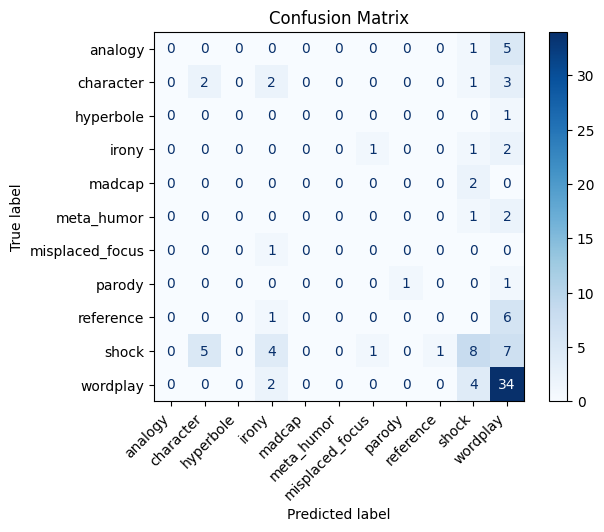

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = cl.log_reg.predict(cl.testX)

cm = confusion_matrix(cl.testY, y_pred, labels=cl.log_reg.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)
    return X, Y

In [ ]:

class Classifier:
    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), use_idf=True)
        self.log_reg = None

        self.trainX = self.vectorizer.fit_transform(trainX)
        self.trainY = trainY
        self.devX = self.vectorizer.transform(devX)
        self.devY = devY
        self.testX = self.vectorizer.transform(testX)
        self.testY = testY



    def train(self):
        best_dev_accuracy = 0
        best_model = None
        for n_estimators in [100, 200, 500]:
            model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
            model.fit(self.trainX, self.trainY)
            training_accuracy = model.score(self.trainX, self.trainY)
            development_accuracy = model.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy = development_accuracy
                best_model = model
            print(f"n_estimators: {n_estimators}, Train accuracy: {training_accuracy:.3f}, Dev accuracy: {development_accuracy:.3f}")

        self.rf_classifier = best_model

    def test(self):
        test_accuracy = self.rf_classifier.score(self.testX, self.testY)
        return test_accuracy
    def print_weights(self, n=10):
        feature_names = self.vectorizer.get_feature_names_out()
        for i, class_label in enumerate(self.rf_classifier.classes_):
            topn = np.argsort(self.rf_classifier.feature_importances_)[-n:]
            print(f"Top features for class {class_label}:")
            for j in topn:
                print(f"{feature_names[j]}: {self.rf_classifier.feature_importances_[j]:.3f}")
            print()


def confidence_intervals(accuracy, n, significance_level=0.05):
    critical_value = (1 - significance_level) / 2
    z_alpha = -1 * norm.ppf(critical_value)
    se = math.sqrt((accuracy * (1 - accuracy)) / n)
    return accuracy - (se * z_alpha), accuracy + (se * z_alpha)

def run(training_file, dev_file, test_file):
    trainX, trainY = load_data(training_file)
    devX, devY = load_data(dev_file)
    testX, testY = load_data(test_file)

    classifier = Classifier(trainX, trainY, devX, devY, testX, testY)
    classifier.train()
    test_accuracy = classifier.test()
    lower, upper = confidence_intervals(test_accuracy, len(testY))
    print(f"Test accuracy for best dev model: {test_accuracy:.3f}, 95% CIs: [{lower:.3f} {upper:.3f}]")

    return classifier

In [ ]:
training_file = "splits/train.txt"
dev_file = "splits/dev.txt"
test_file = "splits/test.txt"

cl = run(training_file, dev_file, test_file)

n_estimators: 100, Train accuracy: 1.000, Dev accuracy: 0.400
n_estimators: 200, Train accuracy: 1.000, Dev accuracy: 0.430
n_estimators: 500, Train accuracy: 1.000, Dev accuracy: 0.450
Test accuracy for best dev model: 0.420, 95% CIs: [0.417 0.423]


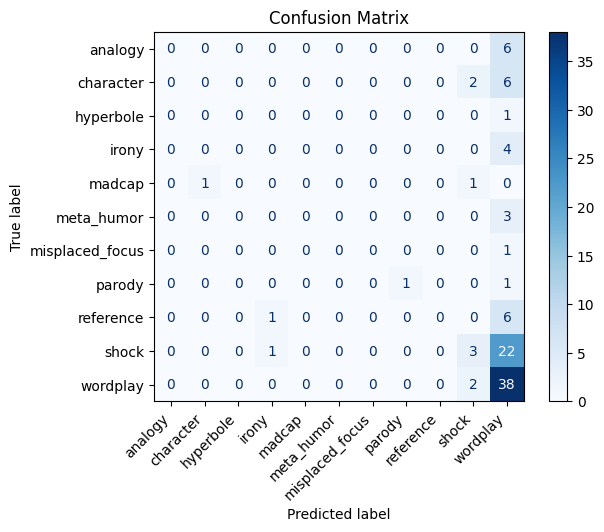

In [ ]:
y_pred = cl.rf_classifier.predict(cl.testX)
cm = confusion_matrix(cl.testY, y_pred, labels=cl.rf_classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()